# EVAC Examination

## Data Exploration

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime
import math


In [223]:
random.seed(datetime.now()) # Set a random seed from the clock

numInputNodes = 7
numHiddenNodes1 = 64
numOutputNodes = 1

IND_SIZE = ((numInputNodes+1) * numHiddenNodes1) +(numHiddenNodes1 * numOutputNodes)



/var/folders/01/z8y87srs6v7g5h7dy9fw6_kr0000gn/T/ipykernel_79663/3200560116.py:1: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(datetime.now()) # Set a random seed from the clock


In [224]:
data = pd.read_csv('eScooterDemand.csv')
data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No,Yes


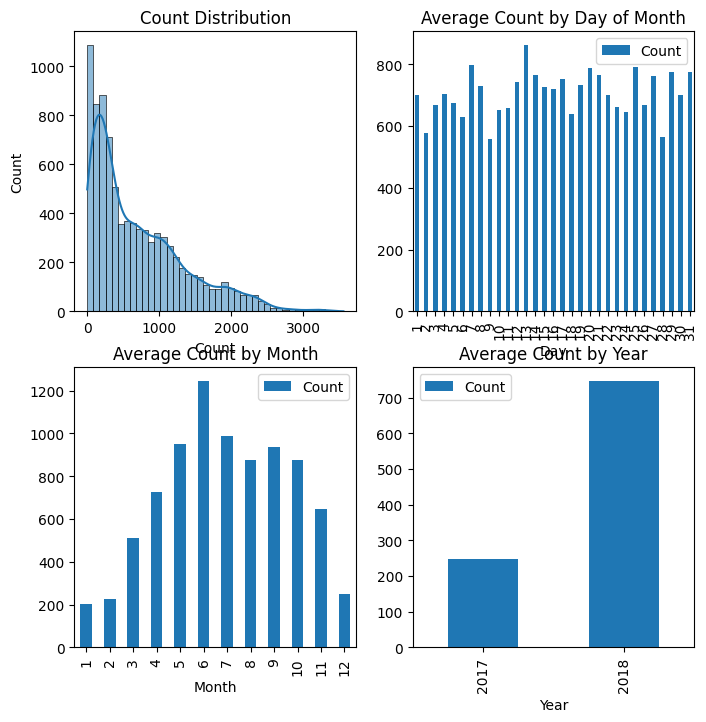

In [225]:


## plot average count over time to look for patterns that can be used to predict future demand
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['Day'] = data['Date'].dt.day

## Show all plots on one figure
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sns.histplot(data['Count'], kde=True, ax=ax[0, 0]).set_title('Count Distribution')
data.groupby('Day').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[0, 1], title='Average Count by Day of Month')
data.groupby('Month').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 0], title='Average Count by Month')
data.groupby('Year').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 1], title='Average Count by Year')
plt.show()


In [226]:
data.query("HireAvailable=='No'").head()


,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day
3144,2018-04-11,0,0,14.4,82,4.6,1041,11.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3145,2018-04-11,0,1,13.6,81,3.6,886,10.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3146,2018-04-11,0,2,12.7,80,3.9,885,9.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3147,2018-04-11,0,3,11.6,81,3.1,687,8.4,0.0,0.0,0.0,Spring,No,No,4,2018,11
3148,2018-04-11,0,4,10.2,83,3.5,554,7.4,0.0,0.0,0.0,Spring,No,No,4,2018,11


## Set up representation

In [227]:
!pip install deap

In [228]:
from deap import base, creator, tools, algorithms, gp, creator
import random
import operator


In [229]:
## Prepare data for training
data['Windspeed'] = data['Wind speed']
data['HireAvailable'] = data['HireAvailable'].map({'Yes': 1, 'No': 0})
data['PublicHoliday'] = data['Public Holiday'].map({'Yes': 1, 'No': 0})
## Create a new column for weekend and assign 1 if the day is a weekend and 0 if it is not from date
data['Weekend'] = data['Date'].dt.dayofweek.map(lambda x: 1 if x > 4 else 0)
data['Season'] = data['Season'].map({'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3})
data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day,Windspeed,PublicHoliday,Weekend
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.2,0,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.8,0,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,3,No,1,12,2017,1,1.0,0,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.9,0,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.3,0,0


In [230]:
data["Count"].describe()

count    8760.000000
mean      704.602055
std       644.997468
min         0.000000
25%       191.000000
50%       504.500000
75%      1065.250000
max      3556.000000
Name: Count, dtype: float64

In [231]:

class MLP(object):
    def __init__(self, numInput, numHidden, numOutput):
        self.fitness = 0
        self.numInput = numInput + 1 # Add bias node to inputs
        self.numHidden = numHidden
        self.numOutput = numOutput

        self.wh = np.random.randn(self.numHidden, self.numInput)
        self.wo = np.random.randn(self.numOutput, self.numHidden)

        self.ReLU = lambda x : max(0,x)

    def sigmoid(self,x):
        try:
            ans = (1 / (1 + math.exp(-x)))
        except OverflowError:
            ans = float('inf')
        return ans
    
    def feedForward(self, inputs):
      inputsBias = inputs[:]
      inputsBias.insert(len(inputs),1)                 # Add bias input
      h1 = np.dot(self.wh, inputsBias)                 # feed to hidden layer
      h1 = [self.ReLU(x) for x in h1]              # Activate hidden layer
      output = np.dot(self.wo, h1)                 # feed to output layer
      # output = [self.sigmoid(x) for x in output]   # Activate output layer
      return output
    
    def getWeightsLinear(self):
        flat_wh = list(self.wh.flatten())
        flat_wo = list(self.wo.flatten())
        return( flat_wh + flat_wo )

    def setWeightsLinear(self, Wgenome):
        numWeights_IH = self.numHidden * (self.numInput)
        self.wh = np.array(Wgenome[:numWeights_IH])
        self.wh = self.wh.reshape((self.numHidden, self.numInput))
        self.wo = np.array(Wgenome[numWeights_IH:])
        self.wo = self.wo.reshape((self.numOutput, self.numHidden))

myNet = MLP(numInputNodes, numHiddenNodes1, numOutputNodes)



In [232]:
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [233]:
import numpy
# randomise data
data = data.sample(frac=1).reset_index(drop=True)
data = data[:500]
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)


In [234]:
def eval(individual, myNet):
  myNet.setWeightsLinear(individual)
  fitness = 0
  for i in range(len(data)):
    input = [ data['Windspeed'][i], data['Visibility'][i], data['PublicHoliday'][i], data['Weekend'][i], data['Month'][i], data['Hour'][i], data['Temp'][i]]
    output = myNet.feedForward(input)
    if output[0] < 0:
      return 1000000000000000,
    fitness += abs(output[0] - data['Count'][i])
  return fitness,


In [235]:
toolbox.register("evaluate", eval)

toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.5, indpb=0.6)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

baseline = toolbox.evaluate(myNet.getWeightsLinear(), myNet)
print(baseline)

(1000000000000000,)


In [236]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [237]:
## SANITYY CHECK
ind = toolbox.individual()
print(ind)
ind.fitness.values = toolbox.evaluate(ind, myNet)
print(ind.fitness.valid)
print(myNet.setWeightsLinear(ind))
print(myNet.feedForward([-10, 4, 3, 2, 1, 5, 5]))
print(toolbox.evaluate(ind, myNet))

[0.5242900867055524, 0.5278184490091085, -0.32403887133206655, 0.7821760167664504, 0.21859756741022407, 0.9620860790196897, 0.487924853195407, -0.4758181281716609, 0.0607751440546358, 0.6627917201795386, -0.09129442284518863, 0.7685200398205598, 0.8863369376574652, 0.025814184630238657, 0.9386050885196877, 0.5824392990285046, -0.47276606437934987, 0.4664518820897383, 0.10141997865327479, 0.14377370536125667, -0.7726775167715536, -0.2165330672033754, -0.9196183807263556, -0.600269208736895, 0.922054321649439, -0.7371649227615475, 0.7689515326782588, -0.2804444604694192, 0.6189304411563248, 0.09097388230996106, -0.2696336304281506, 0.4123061613434216, 0.21233942572164732, -0.058756272866355985, -0.2609765940254518, 0.17056814624122718, 0.7658987806091593, 0.47112541988692325, 0.03184468562773901, -0.12580270424320728, -0.0037205355389140493, -0.9547501336808675, -0.2123843510247101, -0.9610766987997117, 0.08950075268355051, 0.9997199232506828, 0.37928051544861074, -0.8354201634009399, -0

In [238]:
logbook = tools.Logbook()

pop = toolbox.population(n=100)

In [239]:
fitnesses = [toolbox.evaluate(indiv, myNet) for indiv in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

In [240]:
NGEN = 200

for g in range(NGEN):
    print("-- Generation %i --" % g)
      
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values
                         
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(indiv, myNet) for indiv in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
         ind.fitness.values = fit
    
    pop[:] = offspring
    record = stats.compile(pop)
    logbook.record(gen=g, **record)


-- Generation 0 --
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
-- Generation 21 --
-- Generation 22 --
-- Generation 23 --
-- Generation 24 --
-- Generation 25 --
-- Generation 26 --
-- Generation 27 --
-- Generation 28 --
-- Generation 29 --
-- Generation 30 --
-- Generation 31 --
-- Generation 32 --
-- Generation 33 --
-- Generation 34 --
-- Generation 35 --
-- Generation 36 --
-- Generation 37 --
-- Generation 38 --
-- Generation 39 --
-- Generation 40 --
-- Generation 41 --
-- Generation 42 --
-- Generation 43 --
-- Generation 44 --
-- Generation 45 --
-- Generation 46 --
-- Generation 47 --
-- Generation 48 --
-- Generation 49 --
-- Generat

In [241]:
print(logbook)
# import pygraphviz as pgv
# from IPython.display import Image
# best_ind = tools.selBest(pop, 1)[0]
# print(best_ind)
# print(best_ind.fitness)
# nodes, edges, labels = gp.graph(best_ind)

# tree = pgv.AGraph()
# tree.add_nodes_from(nodes)
# tree.add_edges_from(edges)
# tree.layout(prog="dot")

# for i in nodes:
#     n = tree.get_node(i)
#     n.attr["label"] = labels[i]

# treePlot = tree.draw(format="png", prog="dot")
# Image(treePlot)



avg    	gen	max  	min        	std        
4.1e+14	0  	1e+15	243933     	4.91833e+14
3.2e+14	1  	1e+15	232938     	4.66476e+14
3.3e+14	2  	1e+15	247387     	4.70213e+14
3.4e+14	3  	1e+15	228577     	4.73709e+14
3.6e+14	4  	1e+15	251300     	4.8e+14    
3e+14  	5  	1e+15	215449     	4.58258e+14
4e+14  	6  	1e+15	598089     	4.89898e+14
2e+14  	7  	1e+15	252516     	4e+14      
1.9e+14	8  	1e+15	264394     	3.92301e+14
3e+14  	9  	1e+15	201831     	4.58258e+14
3e+14  	10 	1e+15	217458     	4.58258e+14
2.8e+14	11 	1e+15	231651     	4.48999e+14
2.4e+14	12 	1e+15	271272     	4.27083e+14
2.3e+14	13 	1e+15	206976     	4.20833e+14
2.6e+14	14 	1e+15	249861     	4.38634e+14
2e+14  	15 	1e+15	238602     	4e+14      
2.6e+14	16 	1e+15	612929     	4.38634e+14
1.5e+14	17 	1e+15	318320     	3.57071e+14
2.1e+14	18 	1e+15	282343     	4.07308e+14
2.8e+14	19 	1e+15	312426     	4.48999e+14
3.4e+14	20 	1e+15	255989     	4.73709e+14
2.6e+14	21 	1e+15	197498     	4.38634e+14
2.9e+14	22 	1e+15	211400     	4.53

[1.6045829375042509, -6.334655500867533, 5.60423168692506, 1.3306652235534577, 0.8060702777343405, 8.14975246167881, 6.912044276684285, 9.488281809171706, 12.225743348431498, -1.1188277057766007, 0.9979161886410708, 8.812452568307197, -2.096785850480142, -0.2475012750615524, 3.2678565071309826, -2.5610642475737944, -7.543383436290358, -4.406714674886618, -0.08443919046358689, 3.9544524128244123, 6.492812422002119, 1.9547889850608953, -0.08650757946536813, 3.8898671437109935, 4.158026610239004, 0.6937598906627126, 6.02357298800244, 5.133893243933797, 5.312701826854425, -4.680259237680017, 2.1546723011528317, 3.692599382067133, -8.6126451353787, -13.807467554560821, 4.992004348469574, -0.3327874615247415, 6.259374914349357, 5.719047026424231, 5.974305978895182, -7.138871958432679, 1.665203946274814, -5.995846644843935, -4.163189469970481, 1.7729198974060996, 1.7857581122134367, 5.0168278125886605, -6.818915563319116, 6.112495198709512, 7.998743976101431, -1.4514675105795574, -4.531697346

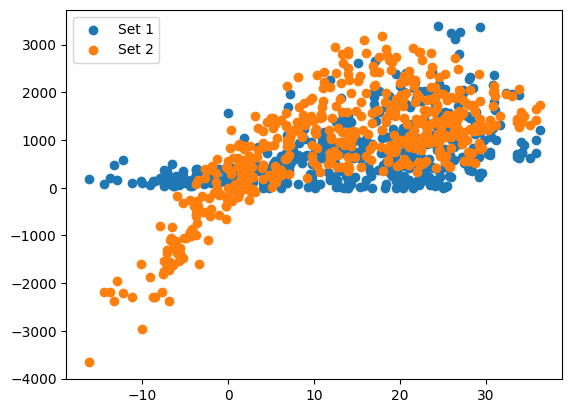

In [242]:
import matplotlib.pyplot as plt

best_ind = tools.selBest(pop, 1)[0]
print(best_ind)
print(toolbox.evaluate(best_ind, myNet))
myNet.setWeightsLinear(best_ind)
print(toolbox.evaluate(best_ind, myNet))

inputs = [[data['Hour'][i],data['Temp'][i], data['Windspeed'][i], data['HireAvailable'][i], data['PublicHoliday'][i], data['Weekend'][i], data['Month'][i]] for i in range(len(data))]
# Assuming you have two sets of data:
x_values1 = data['Temp'].to_list()
y_values1 = data['Count'].to_list()

x_values2 = data['Temp'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

[array([2261.89192212]), array([1515.97640705]), array([-824.56328745]), array([585.67425545]), array([-1058.36972161]), array([1434.97044624]), array([-178.32215959]), array([1105.72304581]), array([1489.35708066]), array([592.18624732]), array([1588.93598875]), array([184.08316704]), array([1760.43361493]), array([768.29745496]), array([2124.74116336]), array([2732.31987153]), array([-729.28425929]), array([1168.8267589]), array([1860.24080771]), array([985.63842301]), array([2023.98385147]), array([875.05748413]), array([1260.16451833]), array([-2366.67768812]), array([179.2906158]), array([2388.23941539]), array([2348.00922882]), array([77.57303712]), array([3095.72240761]), array([1931.28734311]), array([1238.18547208]), array([2421.95545366]), array([928.0307263]), array([1178.45094459]), array([118.11760287]), array([1310.73261854]), array([-1263.12625186]), array([551.0193149]), array([464.07029779]), array([407.39169683]), array([1028.8246008]), array([1513.07913392]), array([

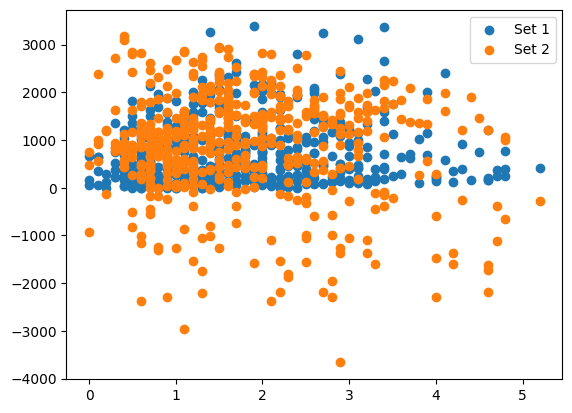

In [243]:
# Assuming you have two sets of data:
x_values1 = data['Windspeed'].to_list()
y_values1 = data['Count'].to_list()

x_values2 = data['Windspeed'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

[array([2261.89192212]), array([1515.97640705]), array([-824.56328745]), array([585.67425545]), array([-1058.36972161]), array([1434.97044624]), array([-178.32215959]), array([1105.72304581]), array([1489.35708066]), array([592.18624732]), array([1588.93598875]), array([184.08316704]), array([1760.43361493]), array([768.29745496]), array([2124.74116336]), array([2732.31987153]), array([-729.28425929]), array([1168.8267589]), array([1860.24080771]), array([985.63842301]), array([2023.98385147]), array([875.05748413]), array([1260.16451833]), array([-2366.67768812]), array([179.2906158]), array([2388.23941539]), array([2348.00922882]), array([77.57303712]), array([3095.72240761]), array([1931.28734311]), array([1238.18547208]), array([2421.95545366]), array([928.0307263]), array([1178.45094459]), array([118.11760287]), array([1310.73261854]), array([-1263.12625186]), array([551.0193149]), array([464.07029779]), array([407.39169683]), array([1028.8246008]), array([1513.07913392]), array([

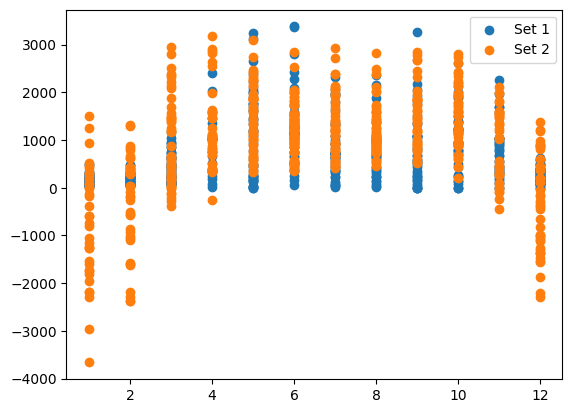

In [244]:
# Assuming you have two sets of data:
x_values1 = data['Month'].to_list()
y_values1 = data['Count'].to_list()

x_values2 = data['Month'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()